In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

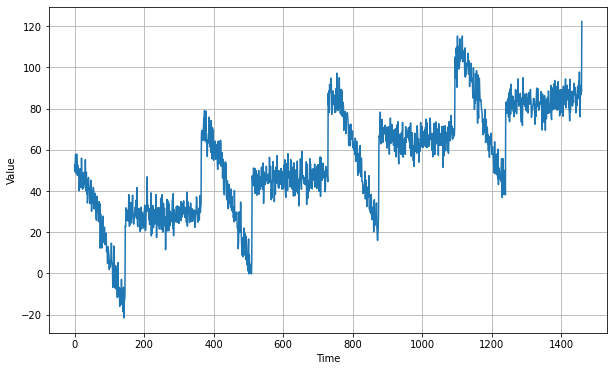

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Simple RNN Forecasting

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 28ms/step - loss: 50.2168 - mae: 50.7165 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 20ms/step - loss: 23.0008 - mae: 23.4932 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 19.2073 - mae: 19.7002 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 16.9701 - mae: 17.4605 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 0s 22ms/step - loss: 15.4093 - mae: 15.8988 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 0s 21ms/step - loss: 14.7507 - mae: 15.2367 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 14.3058 - mae: 14.7931 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 0s 22ms/step - loss: 14.0615 - mae: 14.5512 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 0s 22ms/step - loss: 13.7812 - mae: 14.2687 - lr: 2.5

8/8 [==============================] - 0s 20ms/step - loss: 511.9961 - mae: 512.4954 - lr: 3.9811e-04
Epoch 74/100
8/8 [==============================] - 0s 17ms/step - loss: 903.5359 - mae: 904.0359 - lr: 4.4668e-04
Epoch 75/100
8/8 [==============================] - 0s 18ms/step - loss: 932.2780 - mae: 932.7780 - lr: 5.0119e-04
Epoch 76/100
8/8 [==============================] - 0s 19ms/step - loss: 1193.2205 - mae: 1193.7205 - lr: 5.6234e-04
Epoch 77/100
8/8 [==============================] - 0s 21ms/step - loss: 1297.3864 - mae: 1297.8864 - lr: 6.3096e-04
Epoch 78/100
8/8 [==============================] - 0s 22ms/step - loss: 1665.4647 - mae: 1665.9647 - lr: 7.0795e-04
Epoch 79/100
8/8 [==============================] - 0s 21ms/step - loss: 1742.5496 - mae: 1743.0496 - lr: 7.9433e-04
Epoch 80/100
8/8 [==============================] - 0s 18ms/step - loss: 1941.6901 - mae: 1942.1901 - lr: 8.9125e-04
Epoch 81/100
8/8 [==============================] - 0s 18ms/step - loss: 2179.9646 

(1e-07, 0.0001, 0.0, 30.0)

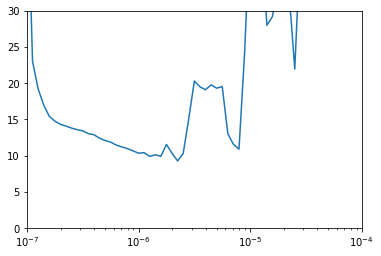

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])